In [1]:
%pylab inline
from collections import OrderedDict
import pickle
import numpy as np
import seaborn as sns
from tqdm import trange
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

import warnings
warnings.filterwarnings('ignore') 

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Data Loading Helper Functions

In [2]:
def rename_groups(df):
    
    """
    Function that takes a dataframe as input
    Returns the same dataframe but with a new category column
    Category column contains updated group labels accounting for different controls
    """
    
    new_cat = []
    
    for row in df.index:
        """
        if df['group'][row].split('_')[0] == 'NGH':
            NGHtype = uuid_NameMap[df['uuid'][row]]
            if NGHtype.split('_')[-1].startswith('05'):
                new_cat.append('Ctrl-LNB')
            elif NGHtype.split('_')[-1].startswith('03'):
                new_cat.append('Ctrl-EE/SI')
        else:
        """
        new_cat.append(df['group'][row].split('_')[0])

    df['category'] = new_cat
    
    return df

In [3]:
def reformat_df(subset_df, metric_interest):
    """
    Take multi-index summary dataframe from Moseq fingerprint code as well as a metric of interest
    Reformat into single index dataframe for further analysis
    Returns dataframe with category label, position, uuid, and avg_time for that uuid in that metric
    """

    category = []
    position = []
    uuid_num = []
    avg_time = []
    
    for ix in subset_df[metric_interest]:
        for cat, uuid in subset_df[metric_interest][ix].index:
            category.append(cat)
            position.append(ix)
            uuid_num.append(uuid)
            avg_time.append(subset_df[metric_interest][ix][cat][uuid])
    
    
    return rename_groups(pd.DataFrame(data={'group': category, 'Metric': position, 'uuid': uuid_num, 'avg_time': avg_time}))


# Load Data

In [4]:
summary_df = pd.read_csv('../../data/fingerprints/full/fingerprint_summary_full.csv', index_col=[0, 1], header=[0, 1])
range_dict = pd.read_csv('../../data/fingerprints/full/fingerprint_summary_full.csv')

In [5]:
males_df = summary_df[summary_df.index.get_level_values('group').str.contains('Male')]

In [6]:
m_pos_df = reformat_df(males_df, 'dist_to_center_px')
m_height_df = reformat_df(males_df, 'height_ave_mm')
m_length_df = reformat_df(males_df, 'length_mm')
m_vel_df = reformat_df(males_df, 'velocity_2d_mm')
m_moseq_df = reformat_df(males_df, 'MoSeq')

m_pos_list = []
m_height_list = []
m_length__list = []
m_vel_list = []
m_moseq_list = []
uuids = []
labels = []

for ix, uuid in enumerate(list(set(m_pos_df['uuid']))):
    labels.append(m_pos_df[m_pos_df['uuid'] == uuid].iloc[1]['category'])
    m_pos_list.append(m_pos_df[m_pos_df['uuid'] == uuid]['avg_time'].values)
    m_height_list.append(m_height_df[m_height_df['uuid'] == uuid]['avg_time'].values)
    m_length__list.append(m_length_df[m_length_df['uuid'] == uuid]['avg_time'].values)
    m_vel_list.append(m_vel_df[m_vel_df['uuid'] == uuid]['avg_time'].values)
    uuids.append(uuid)
    m_moseq_list.append(m_moseq_df[m_moseq_df['uuid'] == uuid]['avg_time'].values)

In [7]:
uuid_vec = np.vstack(uuids)

In [8]:
uuid_vec

array([['2a84130d-6477-4fcc-a644-eb0527024917'],
       ['a30299ff-63d0-4c08-9b26-0cc143eef34b'],
       ['5083529c-320b-4bea-9ceb-d119b2594f13'],
       ['e748a1cc-390a-4924-86dc-30d6c8f3329d'],
       ['b337bf67-7270-42f5-8b72-78dd050c5145'],
       ['72b39b1e-5973-43e2-bedb-0f00ace4848b'],
       ['f32cc80e-36a8-4cf6-823e-478f8eb4af38'],
       ['744530d8-f277-48b3-8627-39c69e04bcde'],
       ['a9a43e79-be6d-43f9-afcc-684fd0bdeafc'],
       ['be2c69ec-d004-4d52-b844-13e9634737ed'],
       ['523977de-8784-4c6e-9d0a-9a8b3a13c38b'],
       ['35e3c7fa-074d-4714-8f40-df91701e6507'],
       ['774ba130-08f1-45ee-9c61-636e6de87827'],
       ['9af80187-1f8b-4a78-bdf6-9cdcaea7c7a8'],
       ['11466614-49c8-4388-91ad-736d6b050085'],
       ['3ac8d60e-8a2c-4244-9761-658ef5682856'],
       ['92b48143-ece8-4749-aff3-73be8f258ece'],
       ['50da788c-2302-41e3-bd7a-8e92b3e24d95'],
       ['6271b7ca-21da-475e-aa9a-021f3fbfe725'],
       ['8425e949-99ab-4e71-baf9-5e653eb68223'],
       ['a86b803c-1a

In [9]:
fingerprints = OrderedDict()
fingerprints['dist_to_center_px'] = np.vstack(m_pos_list)
fingerprints['height_ave_mm'] = np.vstack(m_height_list)
fingerprints['length_mm'] = np.vstack(m_length__list)
fingerprints['velocity_2d_mm'] = np.vstack(m_vel_list)
fingerprints['MoSeq'] = np.vstack(m_moseq_list)

fingerprint_labels = OrderedDict()
fingerprint_labels['condition'] = np.array(labels)

In [10]:
max_len = max([fingerprints[item].shape[1] for item in fingerprints])  # Find the maximum number of features

# Pad all feature vectors to have the same length
for item in fingerprints:
    if fingerprints[item].shape[1] < max_len:
        padding = np.zeros((fingerprints[item].shape[0], max_len - fingerprints[item].shape[1]))
        fingerprints[item] = np.hstack([fingerprints[item], padding])  # Pad with zeros


In [11]:
for key, val in fingerprints.items():
    print(val.shape)

(33, 99)
(33, 99)
(33, 99)
(33, 99)
(33, 99)


In [12]:
X_dist   = fingerprints['dist_to_center_px']   # dist_to_center_px
X_height = fingerprints['height_ave_mm']   # height_ave_mm
X_length = fingerprints['length_mm']   # length_mm
X_vel    = fingerprints['velocity_2d_mm']   # velocity_2d_mm
X_moseq  = fingerprints['MoSeq']   # MoSeq

X = np.hstack([X_dist, X_height, X_length, X_vel, X_moseq])
print(X.shape)

(33, 495)


In [13]:
y = fingerprint_labels['condition'].copy()

In [14]:
y.shape

(33,)

In [15]:
# recode y labels into numerics instead of strings
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_num = le.fit_transform(y)

# Preprocessing

## Scaling

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Hyperparameter Tuning

In [17]:
# ============================================================
# 📂 Section: Model Fitting  ──  Subsection: Hyper-parameter Tuning
# Goal: Tune PCA dimensionality + logistic-reg regularisation
# ============================================================

from sklearn.pipeline          import Pipeline
from sklearn.decomposition     import PCA
from sklearn.linear_model      import LogisticRegression
from sklearn.model_selection   import StratifiedKFold, GridSearchCV
import numpy as np
import joblib

# ------------------------------------------------------------------
# 1) Build the pipeline:  PCA  ➜  multinomial logistic regression
# ------------------------------------------------------------------
pipe = Pipeline([
    ('pca', PCA(random_state=0)),
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        penalty='l2',
        max_iter=10_000,
        n_jobs=-1))
])

# ------------------------------------------------------------------
# 2) Hyper-parameter grid
#    • n_components : either explicit integers  *or*  variance targets
#    • C            : inverse L2 strength   (smaller = stronger penalty)
# ------------------------------------------------------------------
param_grid = {
    'pca__n_components': [5, 8, 10, 12, 15, 0.90, 0.95],
    'clf__C'           : np.logspace(-2, 2, 7)          # 0.01 … 100
}

# ------------------------------------------------------------------
# 3) Stratified 5-fold CV so each class appears in every split
# ------------------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# ------------------------------------------------------------------
# 4) Grid search  (balanced accuracy treats all four classes equally)
# ------------------------------------------------------------------
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1,             # run folds in parallel
    return_train_score=True,
    verbose=2
)

grid.fit(X_scaled, y_num)

print(f"\n🏆  Best balanced-accuracy : {grid.best_score_:.3f}")
print(  "🔧  Best parameters       :", grid.best_params_)

# ------------------------------------------------------------------
# 5) Save the tuned pipeline for later reuse / prediction
# ------------------------------------------------------------------
joblib.dump(grid.best_estimator_, "best_pca_logreg.joblib")


Fitting 5 folds for each of 49 candidates, totalling 245 fits


/om2/user/mabdel03/conda_envs/python_data_analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/om2/user/mabdel03/conda_envs/python_data_analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/om2/user/mabdel03/conda_envs/python_data_analysis/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/om2/user/mabdel03/conda_


🏆  Best balanced-accuracy : 0.775
🔧  Best parameters       : {'clf__C': 4.641588833612777, 'pca__n_components': 0.95}


['best_pca_logreg.joblib']

In [18]:
best_model = grid.best_estimator_

# For variance targets (0.90 / 0.95) this tells you the *integer* count chosen
k = best_model.named_steps['pca'].n_components_
print("The tuned model keeps", k, "principal components")

The tuned model keeps 25 principal components


# Evaluation (Optimal Model)

Cross-validated overall metrics
  Accuracy        : 0.758
  Balanced recall : 0.741
  Macro-F1        : 0.763

Per-class precision / recall / F1
              precision    recall  f1-score   support

          EE      1.000     0.833     0.909         6
         LNB      0.833     0.714     0.769         7
         NGH      0.688     0.846     0.759        13
          SI      0.667     0.571     0.615         7

    accuracy                          0.758        33
   macro avg      0.797     0.741     0.763        33
weighted avg      0.771     0.758     0.758        33



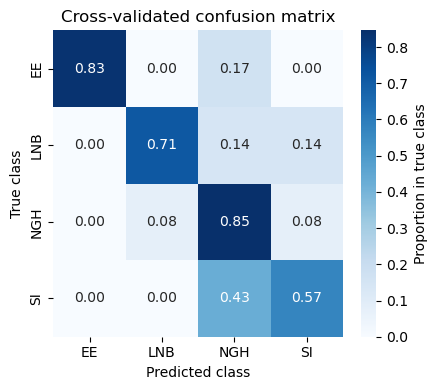

[CV] END ...................clf__C=0.01, pca__n_components=8; total time=   0.0s
[CV] END ................clf__C=0.01, pca__n_components=0.95; total time=   0.0s
[CV] END ...clf__C=0.046415888336127774, pca__n_components=8; total time=   0.0s
[CV] END ..clf__C=0.046415888336127774, pca__n_components=12; total time=   0.0s
[CV] END .clf__C=0.046415888336127774, pca__n_components=0.9; total time=   0.0s
[CV] END ....clf__C=0.21544346900318834, pca__n_components=8; total time=   0.0s
[CV] END ...clf__C=0.21544346900318834, pca__n_components=15; total time=   0.0s
[CV] END ...................clf__C=1.0, pca__n_components=15; total time=   0.0s
[CV] END ...................clf__C=1.0, pca__n_components=15; total time=   0.0s
[CV] END .....clf__C=4.641588833612777, pca__n_components=10; total time=   0.0s
[CV] END .....clf__C=4.641588833612777, pca__n_components=10; total time=   0.0s
[CV] END .....clf__C=21.54434690031882, pca__n_components=10; total time=   0.0s
[CV] END .....clf__C=21.5443

In [19]:
# ============================================================
# 📊  Evaluation cell – metrics + per-class accuracy heat-map
# ============================================================

from sklearn.model_selection import cross_val_predict
from sklearn.metrics         import (
    accuracy_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ------------------------------------------------------------------
# 1) Cross-validated predictions with the tuned pipeline
# ------------------------------------------------------------------
best_model = grid.best_estimator_          # from the previous GridSearch
y_cv_pred  = cross_val_predict(best_model, X_scaled, y_num, cv=cv)

# ------------------------------------------------------------------
# 2) Global metrics
# ------------------------------------------------------------------
print("Cross-validated overall metrics")
print(f"  Accuracy        : {accuracy_score(y_num, y_cv_pred):.3f}")
print(f"  Balanced recall : {recall_score(y_num, y_cv_pred, average='macro'):.3f}")
print(f"  Macro-F1        : {f1_score(y_num, y_cv_pred, average='macro'):.3f}\n")

print("Per-class precision / recall / F1")
print(classification_report(
    y_num, y_cv_pred,
    target_names=['EE', 'LNB', 'NGH', 'SI'],
    digits=3
))

# ------------------------------------------------------------------
# 3) Heat-map of per-class recall (row-normalised confusion matrix)
# ------------------------------------------------------------------
cm       = confusion_matrix(y_num, y_cv_pred)
cm_norm  = cm / cm.sum(axis=1, keepdims=True)      # rows sum to 1
labels   = ['EE', 'LNB', 'NGH', 'SI']
df_cm    = pd.DataFrame(cm_norm, index=labels, columns=labels)

plt.figure(figsize=(4.5, 4))
sns.heatmap(df_cm,
            annot=True, fmt=".2f",
            cmap="Blues",
            cbar_kws={'label': 'Proportion in true class'})
plt.title("Cross-validated confusion matrix")
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

# Evaluate (25 PC Model)

# Misc.

In [60]:
import pandas as pd
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Get PC scores
Z = pca_model.transform(X_scaled)       # shape (33, 12)
pc_df = pd.DataFrame(Z[:, :3], columns=['PC1', 'PC2', 'PC3'])
pc_df['class'] = y                     # original string labels

for pc in ['PC1', 'PC2', 'PC3']:
    groups = [grp[pc].values for name, grp in pc_df.groupby('class')]
    F, p = stats.f_oneway(*groups)
    print(f"{pc}:  F = {F:.2f},  p = {p:.4f}")
    
    if p < 0.05:
        posthoc = pairwise_tukeyhsd(endog=pc_df[pc], groups=pc_df['class'])
        print(posthoc.summary())


PC1:  F = 13.79,  p = 0.0000
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    EE    LNB -12.5468 0.0022 -21.1007  -3.9929   True
    EE    NGH -12.6577 0.0005 -20.2461  -5.0694   True
    EE     SI -19.9847    0.0 -28.5386 -11.4309   True
   LNB    NGH  -0.1109    1.0  -7.3189    7.097  False
   LNB     SI   -7.438  0.087 -15.6563   0.7804  False
   NGH     SI   -7.327 0.0452 -14.5349  -0.1191   True
------------------------------------------------------
PC2:  F = 2.27,  p = 0.1015
PC3:  F = 4.90,  p = 0.0071
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
    EE    LNB  -5.1223 0.2683 -12.6363  2.3917  False
    EE    NGH  -6.5691 0.0546 -13.2349  0.0968  False
    EE     SI    1.077 0.9794   -6.437   8.591  False
   LNB    NGH  -1.4468  0.924  -7.7784  4

In [ ]:
# ===============================================
#  Prepare the 25-D PC matrix and a tidy DataFrame
# ===============================================
import numpy as np, pandas as pd
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multitest     import multipletests
from scipy import stats
from skbio.stats.distance import DistanceMatrix, permanova
from scipy.spatial.distance import pdist, squareform

# 1) 12-D scores
Z12 = best_model.named_steps['pca'].transform(X_scaled)[:, :25]   # (33 × 12)

df = pd.DataFrame(Z12, columns=[f'PC{i+1}' for i in range(25)])
df['group'] = y                         # original string labels ('EE', 'LNB', ...)

# ===============================================
#  STEP 1 — MANOVA
# ===============================================
formula = ' + '.join(df.columns[:-1]) + ' ~ group'        # PC1 + PC2 + ... ~ group
mv = MANOVA.from_formula(formula, data=df)
print("\n=== MANOVA (Wilks’ λ, Pillai’s trace) ===")
print(mv.mv_test())           # shows Wilks, Pillai, Hotelling, Roy

# ===============================================
#  STEP 2 — PC-wise ANOVAs  +  BH FDR
# ===============================================
p_vals = []
for pc in df.columns[:-1]:
    groups = [df.loc[df['group'] == g, pc] for g in df['group'].unique()]
    F, p = stats.f_oneway(*groups)
    p_vals.append(p)

# FDR-correct
rej, p_adj, _, _ = multipletests(p_vals, method='fdr_bh')
pc_results = pd.DataFrame({
    'PC'        : df.columns[:-1],
    'raw_p'     : p_vals,
    'FDR_p'     : p_adj,
    'signif'    : rej
}).sort_values('FDR_p')
print("\n=== PC-wise ANOVA (BH-FDR corrected) ===")
print(pc_results.to_string(index=False))

# ===============================================
#  OPTIONAL — PERMANOVA  (non-parametric backup)
# ===============================================
# Euclidean distances in 12-D space
D = squareform(pdist(Z12, metric='euclidean'))
dm = DistanceMatrix(D, ids=list(range(len(y))))
perma_res = permanova(dm, y, permutations=999)
print("\n=== PERMANOVA on 12-PC Euclidean distances ===")
print(perma_res)

# Embedding Visualization

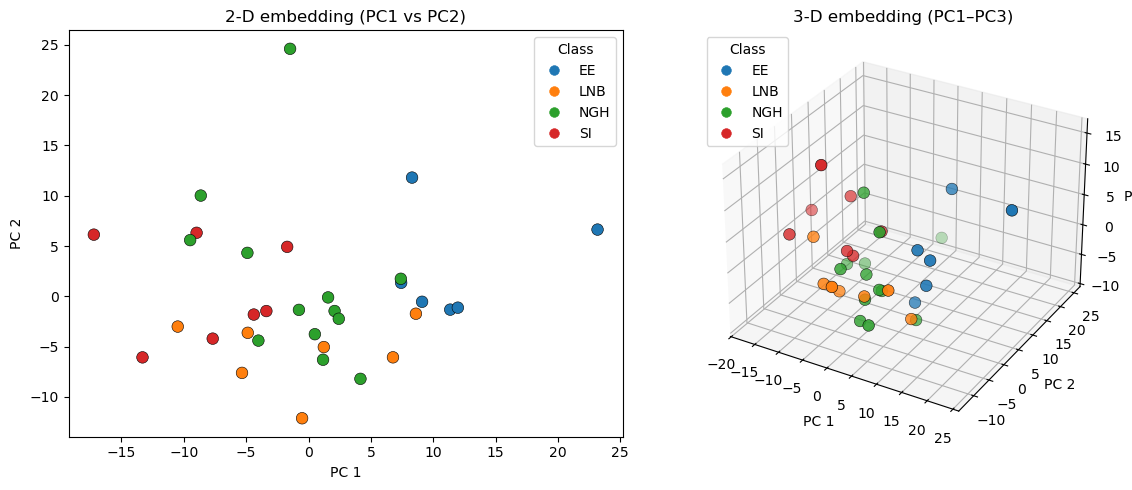

In [61]:
# ============================================================
#  Latent embeddings – PCA space
#  • Left  : PC-1 vs PC-2   (2-D)
#  • Right : PC-1 vs PC-2 vs PC-3  (3-D)
# ============================================================

# %matplotlib widget   # ← uncomment for interactive rotation in Jupyter

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ------------------------------------------------------------------
# 1) Get the latent coordinates from the tuned pipeline
# ------------------------------------------------------------------
pca_model = grid.best_estimator_.named_steps['pca']
Z = pca_model.transform(X_scaled)    # shape (33, 12)
Z2, Z3 = Z[:, :2], Z[:, :3]          # first 2 & first 3 PCs

# ------------------------------------------------------------------
# 2) Categorical tab10 palette (blue, orange, green, red)
# ------------------------------------------------------------------
base_cmap = mpl.cm.get_cmap('tab10')
cat_cmap  = mpl.colors.ListedColormap([base_cmap(i) for i in range(4)])
norm      = mpl.colors.BoundaryNorm(np.arange(-0.5, 4.5), cat_cmap.N)

label_names = ['EE', 'LNB', 'NGH', 'SI']   # order must match label encoding
handles = [mpl.lines.Line2D([], [], marker='o', linestyle='',
                            markersize=7, markeredgewidth=0.4,
                            color=cat_cmap(i), label=lab)
           for i, lab in enumerate(label_names)]

# ------------------------------------------------------------------
# 3) Build the figure – 2-D (left) + 3-D (right)
# ------------------------------------------------------------------
fig = plt.figure(figsize=(12, 5))

# --- 2-D plot ------------------------------------------------------
ax2 = fig.add_subplot(1, 2, 1)
ax2.scatter(Z2[:, 0], Z2[:, 1],
            c=y_num, cmap=cat_cmap, norm=norm,
            s=70, edgecolor='k', linewidth=0.4)
ax2.set_xlabel('PC 1'); ax2.set_ylabel('PC 2')
ax2.set_title('2-D embedding (PC1 vs PC2)')
ax2.legend(handles=handles, title='Class', loc='best')

# --- 3-D plot ------------------------------------------------------
ax3 = fig.add_subplot(1, 2, 2, projection='3d')
ax3.scatter(Z3[:, 0], Z3[:, 1], Z3[:, 2],
            c=y_num, cmap=cat_cmap, norm=norm,
            s=70, edgecolor='k', linewidth=0.4)
ax3.set_xlabel('PC 1'); ax3.set_ylabel('PC 2'); ax3.set_zlabel('PC 3')
ax3.set_title('3-D embedding (PC1–PC3)')

# Use the same legend handles in 3-D (upper-left corner of the panel)
ax3.legend(handles=handles, title='Class', loc='upper left')

plt.tight_layout()
plt.show()


# Saving Objects

In [62]:
# ============================================================
#  Save 12-PC embedding + labels + UUIDs
# ============================================================

import pandas as pd
import numpy as np
import joblib
import os

# ── 1) 12-PC coordinates from the tuned pipeline ─────────────
Z12 = best_model.named_steps['pca'].transform(X_scaled)[:, :25]    # shape (n_samples, 12)

# ── 2) Build a DataFrame --------------------------------------
embed_df = pd.DataFrame(Z12, columns=[f'PC{i+1}' for i in range(25)])

embed_df['category'] = y            # string labels: 'EE', 'LNB', 'NGH', 'SI'
embed_df['uuid']     = uuid_vec        # <- make sure `uuids` is a 1-D array/list aligned with X

# Optional: move label columns to the front
cols = ['uuid', 'category'] + [c for c in embed_df.columns if c.startswith('PC')]
embed_df = embed_df[cols]

# ── 3) Choose an output path ----------------------------------
out_dir = "/om2/user/mabdel03/files/BTI/Moseq_3-27-2025_Run/Offsprings/data/analysis_output/constructed_fingerprints/Males"
os.makedirs(out_dir, exist_ok=True)

csv_path   = os.path.join(out_dir, "offspring_PCA25_embedding.csv.gz")
pkl_path   = os.path.join(out_dir, "offspring_PCA25_embedding.pkl")

# ── 4) Write to disk ------------------------------------------
embed_df.to_csv(csv_path, index=False, compression="gzip")
embed_df.to_pickle(pkl_path)

print(f"✅ Saved 25-PC embedding\n  • {csv_path}\n  • {pkl_path}")

# ── 5) (Optional) save the fitted model itself ----------------
joblib.dump(best_model, os.path.join(out_dir, "pca12_logreg.joblib"))


✅ Saved 25-PC embedding
  • ../../data/analysis_output/constructed_fingerprints/Males/offspring_PCA25_embedding.csv.gz
  • ../../data/analysis_output/constructed_fingerprints/Males/offspring_PCA25_embedding.pkl


['../../data/analysis_output/constructed_fingerprints/Males/pca12_logreg.joblib']

In [37]:
import pandas as pd
embed_df = pd.read_pickle("../../data/analysis_output/constructed_fingerprints/Males/offspring_PCA12_embedding.pkl")
# or: pd.read_csv("...csv.gz")


In [38]:
embed_df

,uuid,category,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
0,b337bf67-7270-42f5-8b72-78dd050c5145,LNB,-10.488839,-3.002693,2.905568,-1.128349,0.443569,-1.597620,3.778469,2.007455,-5.404540,-0.344104,-2.161732,-6.331536
1,744530d8-f277-48b3-8627-39c69e04bcde,LNB,6.768376,-6.057944,-0.305252,-2.608399,-4.249530,1.001843,-3.452490,2.527666,-1.445792,-2.173603,-0.060032,0.885409
2,5083529c-320b-4bea-9ceb-d119b2594f13,NGH,-4.023883,-4.397324,-0.216554,-2.016008,-4.304283,1.271473,7.915787,-3.023034,-2.587772,-0.058257,-3.379206,4.242534
3,6c06a0b7-7ca1-45ef-bb49-6a4589681bf4,NGH,1.565465,-0.103222,-4.465333,2.642781,-3.660184,3.492425,3.454603,-2.102157,0.042256,4.369939,-0.034389,-3.227867
4,72b39b1e-5973-43e2-bedb-0f00ace4848b,NGH,-4.905071,4.324940,8.160634,-5.190738,-4.809472,-5.844770,0.919767,7.314685,1.966583,-4.079778,-1.636514,1.800439
5,be2c69ec-d004-4d52-b844-13e9634737ed,SI,-4.389551,-1.807877,1.482355,8.286113,9.191115,5.183310,3.252200,3.286561,7.841700,-7.637294,-4.526836,-4.065417
6,8425e949-99ab-4e71-baf9-5e653eb68223,NGH,0.503875,-3.760428,-4.447832,-5.219910,4.429200,0.663011,-0.743466,-2.966234,1.896604,3.344076,0.032108,-1.550870
7,e235873b-f363-4a61-8a8c-3e935da3ed3d,LNB,1.223713,-5.039052,-3.133227,0.249150,-3.392989,0.043990,1.714035,-1.361532,-7.007021,-5.363119,1.858615,2.826488
8,a30299ff-63d0-4c08-9b26-0cc143eef34b,LNB,8.607919,-1.724041,-6.601534,-8.492956,7.224147,-3.659863,-4.007939,-1.888752,-2.274200,-0.833618,0.167571,0.988351
9,774ba130-08f1-45ee-9c61-636e6de87827,SI,-13.315558,-6.063129,3.998677,4.385434,5.828232,-0.810497,3.810909,-1.307332,2.238548,-2.521039,2.730162,4.169906
